# Plot Figure 3

This code plots the observed and POD-predicted regional-mean monthly precipitation changes for HR-ERA5/IMERG, LR-ERA5/IMERG, and LR-ERA5/GPCP (Figure 3).

## Import Necessary Packages

In [1]:
import warnings
import numpy as np
import xarray as xr
from numba import jit
import proplot as pplt
from matplotlib.lines import Line2D
pplt.rc['tick.minor']=False
warnings.filterwarnings('ignore')

## User-Defined Configurations

Specify the directory where the P-$B_L$ datasets are, and set the directory where the figure will be saved. Define regions of interest with their respective latitude/longitude bounds, and set binning parameters for $B_L$/$\mathrm{CAPE_L}$/$\mathrm{SUBSAT_L}$. Specify "monthly pairs" for analysis (i.e., `MONTHPAIRS = [(6,7),(7,8)]` for June-to-July and July-to-August changes). Set the precipitation threhsold (in mm/day) distinguishing precipitating from non-precipitating regimes, and the minimum sample threshold for bin inclusion for statistical calculations. For bootstrapping, define the number of iterations, years of data per bootstrap sample, and the confidence level for uncertainty error bars.

In [2]:
FILEDIR       = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed'
SAVEDIR       = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/figs'
REGIONS       = {'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
                 'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
                 'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
                 'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
                 'Konkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
BINPARAMS     = {'bl':{'min':-0.6,'max':0.1,'width':0.0025},
                 'cape':{'min':-70.,'max':20.,'width':1.},
                 'subsat':{'min':-20.,'max':70.,'width':1.}}
MONTHPAIRS    = [(6,7),(7,8)]
PRTHRESH      = 0.25
SAMPLETHRESH  = 50
NITERATIONS   = 1000
YEARSINSAMPLE = 5
CONFIDENCE    = 0.95

## Load P-$B_L$ Datasets

Load in precipitation and $B_L$ from each P-$B_L$ dataset (stored in `FILEDIR`).

In [3]:
def load(filename,filedir=FILEDIR,varlist=None):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    if varlist:
        ds = ds[varlist]
    return ds.load()

In [4]:
hrimergprbl = load('LR_ERA5_IMERG_pr_bl_terms.nc',varlist=['pr','bl'])
lrimergprbl = load('LR_ERA5_IMERG_pr_bl_terms.nc',varlist=['pr','bl'])
lrgpcpprbl  = load('LR_ERA5_GPCP_pr_bl_terms.nc',varlist=['pr','bl'])

## Functions for Analysis and Plotting

The `get_region()` and `get_month()` functions subset a given P-$B_L$ dataset by the the region and month(s) of interest, respectively.

In [5]:
def get_region(data,key,regions=REGIONS):
    region = regions[key]
    return data.sel(lat=slice(region['latmin'],region['latmax']),lon=slice(region['lonmin'],region['lonmax']))

def get_month(data,months):
    if not isinstance(months,(list,tuple)):
        months = [months]
    monthmask = data.time.dt.month.isin(months)
    return data.sel(time=monthmask)

The `calc_binned_stats()` function performs statistical analysis using either 1-D ($B_L$), 2-D (joint $\mathrm{SUBSAT_L}$-$\mathrm{CAPE_L}$), or both binning schemes, as specificed by the `bintype` parameter. For each bin in the scheme(s), it calculates two statistics: the total count of data points (Q0 for 1-D, P0 for 2-D), and the sum of precipitation values (Q1 for 1-D and P1 for 2-D). To optimize performance, the function utilizes [Numba's just-in-time](https://numba.readthedocs.io/en/stable/user/jit.html) compilation. The resulting statistics are then structured and stored in an Xarray.Dataset.

In [6]:
def get_bin_edges(key,binparams=BINPARAMS):
    varname  = binparams[key]
    return np.arange(varname['min'],varname['max']+varname['width'],varname['width'])
     
@jit(nopython=True)
def fast_1D_binned_stats(blidxs,prdata,nblbins,prthresh=PRTHRESH):
    Q0 = np.zeros(nblbins)
    QE = np.zeros(nblbins)
    Q1 = np.zeros(nblbins)
    for i in range(prdata.size):
        blidx = blidxs.flat[i]
        prval = prdata.flat[i]
        if 0<=blidx<nblbins and np.isfinite(prval):
            Q0[blidx] += 1
            Q1[blidx] += prval
            if prval>prthresh:
                QE[blidx] += 1
    return Q0,QE,Q1

@jit(nopython=True)
def fast_2D_binned_stats(capeidxs,subsatidxs,prdata,ncapebins,nsubsatbins,prthresh=PRTHRESH):
    P0 = np.zeros((nsubsatbins,ncapebins))
    PE = np.zeros((nsubsatbins,ncapebins))
    P1 = np.zeros((nsubsatbins,ncapebins))
    for i in range(prdata.size):
        capeidx = capeidxs.flat[i]
        subsatidx = subsatidxs.flat[i]
        prval = prdata.flat[i]
        if 0<=subsatidx<nsubsatbins and 0<=capeidx<ncapebins and np.isfinite(prval):
            P0[subsatidx,capeidx] += 1
            P1[subsatidx,capeidx] += prval
            if prval>prthresh:
                PE[subsatidx,capeidx] += 1
    return P0,PE,P1

def calc_binned_stats(data,bintype='both',binparams=BINPARAMS,prthresh=PRTHRESH):
    if bintype not in ['1D','2D','both']:
        raise ValueError("Bin type must be '1D', '2D', or 'both'")
    ds = xr.Dataset()
    if bintype in ['1D','both']:
        blbins = get_bin_edges('bl',binparams)
        blidxs = ((data.bl.values-binparams['bl']['min'])/binparams['bl']['width']+0.5).astype(np.int32)
        Q0,QE,Q1 = fast_1D_binned_stats(blidxs,data.pr.values,blbins.size,prthresh)
        ds['Q0'] = ('bl',Q0)
        ds['QE'] = ('bl',QE)
        ds['Q1'] = ('bl',Q1)
        ds['bl'] = blbins
        ds.Q0.attrs = dict(long_name='Count of points in each bin')
        ds.QE.attrs = dict(long_name=f'Count of precipitating ( > {prthresh} mm/day) points in each bin')
        ds.Q1.attrs = dict(long_name='Sum of precipitation in each bin', units='mm/day')
        ds.bl.attrs = dict(long_name='Average buoyancy in the lower troposphere', units='m/s²')
    if bintype in ['2D','both']:
        capebins   = get_bin_edges('cape',binparams)
        subsatbins = get_bin_edges('subsat',binparams)
        capeidxs   = ((data.cape.values-binparams['cape']['min'])/binparams['cape']['width']-0.5).astype(np.int32)
        subsatidxs = ((data.subsat.values-binparams['subsat']['min'])/binparams['subsat']['width']-0.5).astype(np.int32)
        P0,PE,P1 = fast_2D_binned_stats(capeidxs,subsatidxs,data.pr.values,capebins.size,subsatbins.size,prthresh)
        ds['P0']     = (('subsat','cape'),P0)
        ds['PE']     = (('subsat','cape'),PE)
        ds['P1']     = (('subsat','cape'),P1)
        ds['cape']   = capebins
        ds['subsat'] = subsatbins
        ds.P0.attrs     = dict(long_name='Count of points in each bin')
        ds.PE.attrs     = dict(long_name=f'Count of precipitating ( > {prthresh} mm/day) points in each bin')
        ds.P1.attrs     = dict(long_name='Sum of precipitation in each bin', units='mm/day')
        ds.cape.attrs   = dict(long_name='Undilute plume buoyancy', units='K')
        ds.subsat.attrs = dict(long_name='Subsaturation in the lower free-troposphere', units='K')
    return ds

Here, we use the `get_bin_mean_pr()` function to calculate the mean precipitation in each $B_L$ bin (for bins where the number of samples exceeds `SAMPLETHRESH`), as well as the `get_pdf()` function to calculate the $B_L$ PDF.

In [7]:
def get_bin_mean_pr(stats,bintype,samplethresh=SAMPLETHRESH):
    if bintype not in ['1D','2D']:
        raise ValueError("Bin type must be '1D' or '2D'")
    if bintype=='1D':
        blbins = stats.bl.values
        Q0 = stats.Q0.values
        Q1 = stats.Q1.values
        Q0[Q0==0.0] = np.nan
        binmeanpr = Q1/Q0
        binmeanpr[Q0<samplethresh] = np.nan
        return xr.DataArray(binmeanpr,coords={'bl':blbins})
    if bintype=='2D':
        subsatbins = stats.subsat.values
        capebins   = stats.cape.values
        P0 = stats.P0.values
        P1 = stats.P1.values
        P0[P0==0.0] = np.nan
        binmeanpr = P1/P0
        binmeanpr[P0<samplethresh] = np.nan
        return xr.DataArray(binmeanpr,coords={'subsat':subsatbins,'cape':capebins})

def get_pdf(stats,bintype,precipitating=False):
    if bintype not in ['1D','2D']:
        raise ValueError("Bin type must be '1D' or '2D'")    
    if bintype=='1D':
        blbins = stats.bl.values
        Q0 = stats.Q0.values
        QE = stats.QE.values
        Q  = QE if precipitating else Q0
        norm = np.nansum(Q0)*np.diff(blbins)[0]
        pdf  = Q/norm
        return xr.DataArray(pdf,coords={'bl':blbins})
    if bintype=='2D':
        subsatbins = stats.subsat.values
        capebins   = stats.cape.values
        P0 = stats.P0.values
        PE = stats.PE.values
        P  = PE if precipitating else P0
        norm = np.nansum(P0)*np.diff(subsatbins)[0]*np.diff(capebins)[0]
        pdf  = P/norm
        return xr.DataArray(pdf,coords={'subsat':subsatbins,'cape':capebins})

The `get_bootstrap_samples()` function generates multiple iterations of the dataset (specified by `NITERATIONS`) by randomly selecting years from the input data, which each iteration containing a specified number of years (defined by `YEARSINSAMPLE`). The `calc_regional_pr_changes()` function computes regional-mean observed and POD-predicted precipitation changes for a specific region and month pair. The main function, `calc_pr_changes_with_bootstrap()`, orchestrates the analysis by calculating regional-mean precipitation changes for both original and bootstrapped data. It calculates these precipitation changes from the original data, and uses a botstrapping procedure to estimate uncertainty in these results (via confidence intervals).

In [8]:
def get_bootstrap_samples(data,niterations=NITERATIONS,yearsinsample=YEARSINSAMPLE):
    allyears = np.unique(data.time.dt.year.values)
    yearidxs = np.random.choice(len(allyears),size=(niterations,yearsinsample),replace=True)
    bootstrapsamples = []
    for iterationidxs in yearidxs:
        selectedyears = allyears[iterationidxs]
        sample = data.sel(time=data.time.dt.year.isin(selectedyears))
        bootstrapsamples.append(sample)
    return bootstrapsamples
    
def calc_regional_pr_changes(regiondata,monthpair,binparams=BINPARAMS,samplethresh=SAMPLETHRESH,prthresh=PRTHRESH):
    regionstats = calc_binned_stats(regiondata,'1D',binparams,prthresh)
    binmeanpr   = get_bin_mean_pr(regionstats,'1D',samplethresh)
    obsprlist   = []
    predprlist  = []
    for month in monthpair:
        monthdata   = get_month(regiondata,month)
        monthstats  = calc_binned_stats(monthdata,'1D',binparams,prthresh)
        blpdf       = get_pdf(monthstats,'1D',precipitating=False)
        blbinwidth  = np.diff(monthstats.bl.values)[0]
        predpr = np.nansum(binmeanpr*blpdf*blbinwidth)
        obspr  = monthdata.pr.mean(dim=['lat','lon','time']).values
        obsprlist.append(obspr)
        predprlist.append(predpr)
    obsprchange  = obsprlist[1]-obsprlist[0]
    predprchange = predprlist[1]-predprlist[0]
    return obsprchange,predprchange

def calc_pr_changes_with_bootstrap(data,regions=REGIONS,monthpairs=MONTHPAIRS,binparams=BINPARAMS,samplethresh=SAMPLETHRESH,
                                   prthresh=PRTHRESH,niterations=NITERATIONS,yearsinsample=YEARSINSAMPLE,confidence=CONFIDENCE):
    def calc_pr_changes(data):
        prchanges = []
        for i,region in enumerate(regions):
            monthpair  = monthpairs[0] if i<3 else monthpairs[1]
            regiondata = get_month(get_region(data,region),monthpair)
            obsprchange,predprchange = calc_regional_pr_changes(regiondata,monthpair,binparams,samplethresh,prthresh)
            prchanges.append((obsprchange,predprchange))
        return prchanges
    meanprchanges      = calc_pr_changes(data)
    bootstrapsamples   = get_bootstrap_samples(data,niterations,yearsinsample)
    bootstrapprchanges = [calc_pr_changes(sample) for sample in bootstrapsamples]
    meanprchanges      = xr.DataArray(meanprchanges,dims=['region','type'],
                                      coords={'region':list(regions.keys()),'type':['observed','predicted']})
    bootstrapprchanges = xr.DataArray(bootstrapprchanges,dims=['iteration','region','type'],
                                      coords={'region':list(regions.keys()),'type':['observed','predicted']})
    diff = bootstrapprchanges-meanprchanges
    lowerpercentile = (1-confidence)/2
    upperpercentile = 1-lowerpercentile
    cilower = meanprchanges-diff.quantile(upperpercentile,dim='iteration')
    ciupper = meanprchanges-diff.quantile(lowerpercentile,dim='iteration')
    yerr = xr.concat([meanprchanges-cilower,ciupper-meanprchanges],dim='ci')
    return meanprchanges,yerr

After the observed and POD-predicted regional-mean precipitation changes (and their errors) are calculated, the `create_plot()` function generates a formatted figure, plotting the results for all three datasets.

In [9]:
def create_plot(datadict,filename=None):
    prchangelist = [item[0] for item in datadict]
    yerrlist     = [item[1] for item in datadict]
    namelist     = [item[2] for item in datadict]    
    regions  = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
    colors   = ['#D42028','#F2C85E','#5BA7DA']
    offsets  = [-0.25,0,0.25]
    fig,ax   = pplt.subplots(refheight=1.8,refwidth=4)
    ax.format(xlim=(-0.5,len(regions)-0.5),xticks=range(len(regions)),xticklabels=regions,grid=False,ygrid=True,
              ylabel='$\Delta$Precipitation (mm/day)',ylim=(-9,9),yticks=3)
    ax.text(x=1.15,y=ax.get_ylim()[1]+1,s='July $-$ June',ha='center',va='bottom')
    ax.text(x=3.3,y=ax.get_ylim()[1]+1,s='August $-$ July',ha='center',va='bottom')
    ax.axvline(x=2.5,color='k',linewidth=1,zorder=0)
    ax.axhline(y=0,color='k',linestyle='--',linewidth=1,zorder=0)
    for prchange,yerr,name,offset,color in zip(prchangelist,yerrlist,namelist,offsets,colors):
        x = np.arange(len(regions))
        ax.errorbar(x+offset-0.05,prchange.sel(type='observed'),yerr=yerr.sel(type='observed'),
                    color=color,marker='.',markersize=6,linestyle='',capsize=2)
        ax.errorbar(x+offset+0.05,prchange.sel(type='predicted'),yerr=yerr.sel(type='predicted'),
                    color=color,marker='x',markersize=6,linestyle='',capsize=2,label=f'Predicted {name}')
    handles = [Line2D([0],[0],color=color,label=name) for color,name in zip(colors,namelist)]
    handles += [Line2D([0],[0],color='k',marker='.',linestyle='',label='Observed'),
                Line2D([0],[0],color='k',marker='x',linestyle='',label='Predicted')]
    ax.legend(handles=handles,loc='r',ncols=1)
    ax.xaxis.set_minor_locator(pplt.NullLocator())
    pplt.show()
    if filename:
        fig.save(f'{SAVEDIR}/{filename}',dpi=900)

## Plot and Save Figure

Compute the observed and POD-predicted regional-mean precipitation changes, execute plotting, and save the figure to the `SAVEDIR`.

In [10]:
hrimergprchanges,hrimergyerr = calc_pr_changes_with_bootstrap(hrimergprbl)
lrimergprchanges,lrimergyerr = calc_pr_changes_with_bootstrap(lrimergprbl)
lrgpcpprchanges,lrgpcpyerr   = calc_pr_changes_with_bootstrap(lrgpcpprbl)

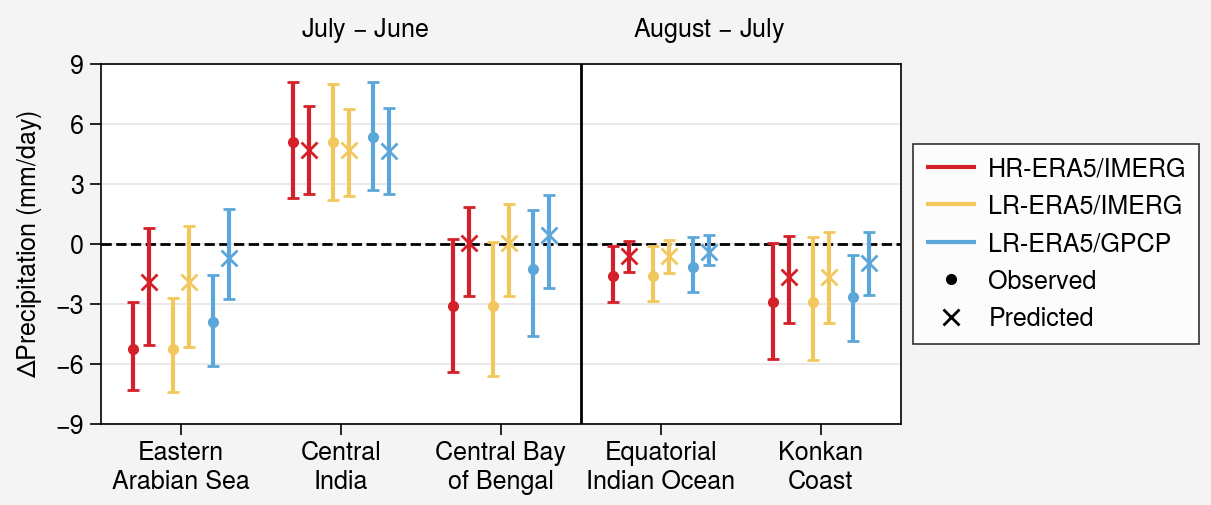

In [11]:
datadict = [
    (hrimergprchanges,hrimergyerr,'HR-ERA5/IMERG'),
    (lrimergprchanges,lrimergyerr,'LR-ERA5/IMERG'),
    (lrgpcpprchanges,lrgpcpyerr,'LR-ERA5/GPCP')]
create_plot(datadict,filename='fig_3.jpg')